In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

In [97]:
def preprocess_data(df):
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Create temporal features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day
    
    #drop column row_id
    df.drop('row_id',axis=1,inplace=True)
    
    # Encode categorical variables
    le_country = LabelEncoder()
    le_store = LabelEncoder()
    le_product = LabelEncoder()
    
    df['country_encoded'] = le_country.fit_transform(df['country'])
    df['store_encoded'] = le_store.fit_transform(df['store'])
    df['product_encoded'] = le_product.fit_transform(df['product'])
    
    # Save the label encoders for later use in the Streamlit app
    os.makedirs('models', exist_ok=True)
    joblib.dump(le_country, 'models/le_country.pkl')
    joblib.dump(le_store, 'models/le_store.pkl')
    joblib.dump(le_product, 'models/le_product.pkl')
    
    return df

In [98]:
# Define feature columns
def get_feature_columns():
    return ['year', 'month', 'day_of_week', 'day_of_month', 
            'country_encoded', 'store_encoded', 'product_encoded']

In [99]:
def train_model(df):
    print("Preprocessing data...")
    df = preprocess_data(df)
    features = get_feature_columns()
    target = 'num_sold'
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=3, test_size= 0.2)
    
    print("Training XGBoost model...")
    xgb_model = XGBRegressor(random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
    xgb_mae = mean_absolute_error(y_test, xgb_predictions)
    xgb_r2 = r2_score(y_test, xgb_predictions)
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=y_test.reset_index(drop=True), label='Actual')
    sns.lineplot(data=pd.Series(xgb_predictions), label='Predicted')
    plt.title('Time Series: Actual vs Predicted Values')
    plt.xlabel('Observation Index')
    plt.ylabel('num_sold')
    plt.legend()
    plt.savefig('models/time_series_actual_vs_predicted.png')
    
    plt.figure(figsize=(12, 6))
    corre=df.corr(numeric_only=True)
    sns.heatmap(corre,annot=True,cmap="Blues")
    plt.show()
    
    print(f"XGBoost:")
    print(f"RMSE: {xgb_rmse:.2f}")
    print(f"MAE: {xgb_mae:.2f}")
    print(f"R2: {xgb_r2:.2f}")
    
    joblib.dump(xgb_model, f'models/xgboost_model.pkl')
    with open('models/best_model.txt', 'w') as f:
        f.write(f"XGBoost:\n")
        f.write(f"RMSE: {xgb_rmse:.2f}\n")
        f.write(f"MAE: {xgb_mae:.2f}\n")
        f.write(f"R2: {xgb_r2:.2f}")
        

Loading data...
Training models...
Preprocessing data...
Training XGBoost model...


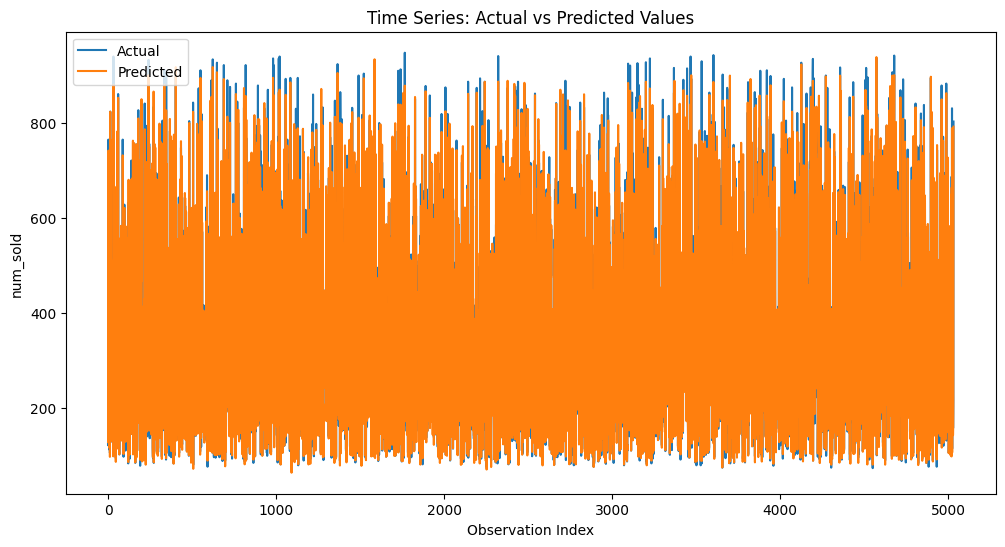

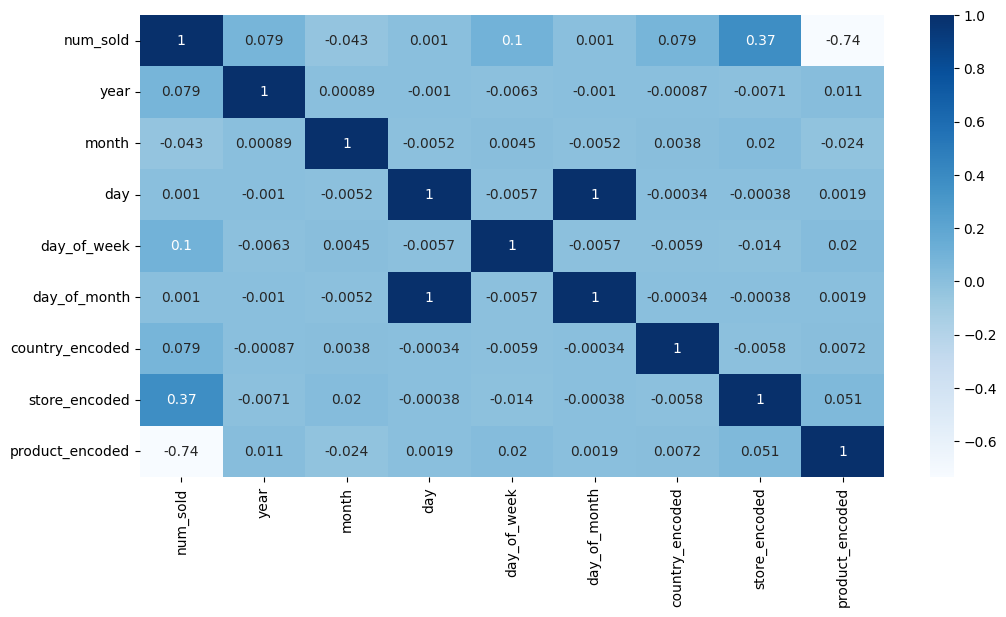

XGBoost:
RMSE: 25.11
MAE: 17.17
R2: 0.98


In [100]:
if __name__ == '__main__':
    print("Loading data...")
    df = pd.read_csv('../Dataset/data_after_EDA.csv')
    
    print("Training models...")
    train_model(df)